Comments

- Check if Random Forest (or any other model) is overfitting and explain why
- Fine-tune the hyperparameters of the best 2 performing "traditional" Machine Learning models
- Try to run the best 2 performing models without Sampling the data ! (you can shuffle it if and only if the temporal information has been taken featue engineered not to lose info aka. timestamp)
- Incorporate the temporal imformation in the training of the traditional ML models too - Ask Hindy, it is related to the Data part of which Vidur is in charge
- Add AUROC as a evaluation metrics
- Build an ensemble tree method alongside debuging  KNN, SVM, LightGBM, etc.
- Look at past papers on our dataset and see if they have used other kind of tradutional models and how they have evaluated/interpreted it all


### Data Preparation

Before training models, there are still a few things we should do. Let us check imbalance in our dataset classes, resample, and later shuffle teh data. 


In [1]:
# import our data
import pickle

# Load the data from the pickle file
with open("withoutpca_train_test_data.pkl", "rb") as f:
    X_train_, X_test_, y_train_, y_test_ = pickle.load(f)

# Check the shapes of the imported data
print("X_train_final shape:", X_train_.shape)
print("X_test_final shape:", X_test_.shape)
print("y_train_encoded shape:", y_train_.shape)
print("y_test shape:", y_test_.shape)

print(y_test_)



X_train_final shape: (91589, 829)
X_test_final shape: (10177, 829)
y_train_encoded shape: (91589,)
y_test shape: (10177,)
[2 1 2 ... 2 0 1]


In [2]:
import numpy as np

# Check class distribution
unique_classes, class_counts = np.unique(y_train_, return_counts=True)
class_distribution = dict(zip(unique_classes, class_counts))
class_distribution = {int(k): int(v) for k, v in class_distribution.items()}

print("Class Distribution in y_train_encoded:", class_distribution)

Class Distribution in y_train_encoded: {0: 10245, 1: 31989, 2: 49355}


As we can see, we need to oversample class 0 and downsample class 2. We do not use SMOTE or ASYN cause some dependency problems arise. 

In [3]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from collections import Counter
import pandas as pd

# Step 1: Define the dataset
X_train = X_train_.copy()
y_train = y_train_.copy()

print("Original class distribution:")
print(Counter({int(k): int(v) for k, v in Counter(y_train).items()}))

# Step 2: Identify classes and their counts
classes, counts = np.unique(y_train, return_counts=True)
max_count = counts.max()

# Step 3: Initialize placeholders for synthetic samples
X_synthetic = []
y_synthetic = []

# Step 4: Oversample each minority class
k_neighbors = 5
for cls, count in zip(classes, counts):
    if count < max_count:
        n_samples_to_generate = max_count - count
        
        # Get minority class samples
        X_minority = X_train[y_train == cls]
        
        # Convert to numpy array if it's a DataFrame
        X_minority_values = X_minority.values if isinstance(X_minority, pd.DataFrame) else X_minority
        
        # Fit nearest neighbors
        nbrs = NearestNeighbors(n_neighbors=k_neighbors).fit(X_minority_values)
        indices = nbrs.kneighbors(X_minority_values, return_distance=False)

        # Generate synthetic samples
        synthetic_samples = []
        for _ in range(n_samples_to_generate):
            idx = np.random.randint(0, len(X_minority_values))
            nn_idx = indices[idx][np.random.randint(1, k_neighbors)]
            
            # Use numpy array indexing
            diff = X_minority_values[nn_idx] - X_minority_values[idx]
            synthetic_sample = X_minority_values[idx] + np.random.rand() * diff
            
            synthetic_samples.append(synthetic_sample)

        synthetic_samples = np.array(synthetic_samples)
        X_synthetic.append(synthetic_samples)
        y_synthetic.append(np.full(n_samples_to_generate, cls))

# Step 5: Combine synthetic samples with original dataset
X_synthetic = np.vstack(X_synthetic) if X_synthetic else np.empty((0, X_train.shape[1]))
y_synthetic = np.hstack(y_synthetic) if y_synthetic else np.empty((0,))

# Convert X_train to numpy array
X_train_values = X_train.values if isinstance(X_train, pd.DataFrame) else X_train

# Combine original and synthetic samples
X_train_balanced = np.vstack([X_train_values, X_synthetic])
y_train_balanced = np.hstack([y_train, y_synthetic])

# Step 6: Verify the new class distribution
print("\nBalanced class distribution:")
print(Counter({int(k): int(v) for k, v in Counter(y_train_balanced).items()}))

# Step 7: Output shapes
print("\nBalanced dataset shapes:")
print(f"Features shape: {X_train_balanced.shape}")
print(f"Target shape: {y_train_balanced.shape}")

Original class distribution:
Counter({2: 49355, 1: 31989, 0: 10245})

Balanced class distribution:
Counter({1: 49355, 2: 49355, 0: 49355})

Balanced dataset shapes:
Features shape: (148065, 829)
Target shape: (148065,)


In [4]:
from sklearn.utils import shuffle

# Combine features and labels into a single dataset for shuffling
X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)

# Verify the shapes after shuffling
print("Shuffled dataset shapes:")
print(f"Features shape: {X_train_balanced.shape}")
print(f"Target shape: {y_train_balanced.shape}")

print(y_train_balanced)


Shuffled dataset shapes:
Features shape: (148065, 829)
Target shape: (148065,)
[2 1 0 ... 1 1 0]


### Baseline Models
**Listed below are our baseline models**

- Logistic Regression
- LightGBM
- K-Nearest Neighbours
- XGBoost
- Support Vector Machine
- random Forest (not used because lacks explanability)
---
**Model evaluation and selection**
- Metrics like confusion matrices, classification reports ROC curves and AUC are generated for each respective model to evaluate their performances.
- K-fold cross validation and hyperparameter tuning will be applied to better-performing models to detect overfitting and achieve a better balance between overfitting and accuracy.


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train_balanced, y_train_balanced, test_size=0.2, random_state=42
)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(118452, 829) (29613, 829) (118452,) (29613,)


## 1. Logistic Regression

Elastic Net Regularisation

In [14]:
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

# First scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test_)
X_val_scaled = scaler.transform(X_val)

# Use Lasso for feature selection
lasso = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', random_state=42)
selector = SelectFromModel(lasso, max_features=100)  # adjust max_features as needed

# Fit and transform training data
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)
X_val_selected = selector.transform(X_val_scaled)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



Model Performance:
Training Accuracy: 0.4852
Validation Accuracy: 0.4859
Accuracy Difference (Training - Validation): -0.0007
Classification Report:

                precision    recall  f1-score   support

readmitted_<30       0.51      0.42      0.46     39349
readmitted_>30       0.43      0.40      0.42     39584
 readmitted_NO       0.51      0.63      0.56     39519

      accuracy                           0.49    118452
     macro avg       0.48      0.49      0.48    118452
  weighted avg       0.48      0.49      0.48    118452



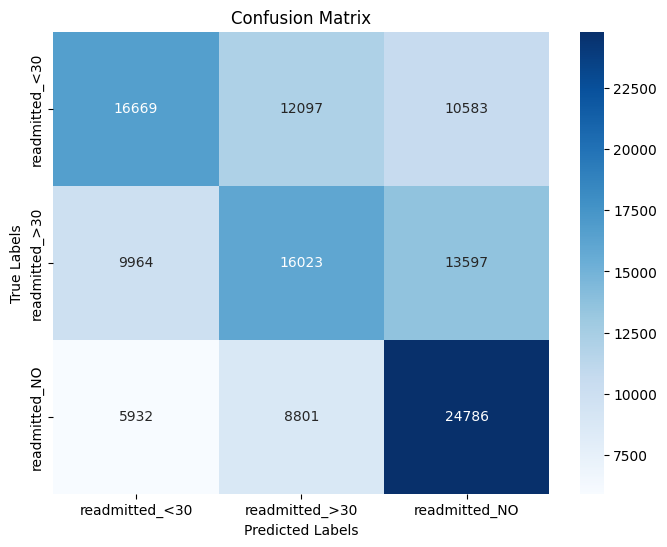

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


# Now apply regular logistic regression
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_selected, y_train)

# Make predictions
y_train_pred = logreg.predict(X_train_selected)
y_val_pred = logreg.predict(X_val_selected)

# Step 4: Evaluate the model
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
accuracy_diff = train_accuracy - val_accuracy

print(f"\nModel Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Accuracy Difference (Training - Validation): {accuracy_diff:.4f}")

# Classification Report
print("Classification Report:\n")
print(classification_report(y_train, y_train_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"], yticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

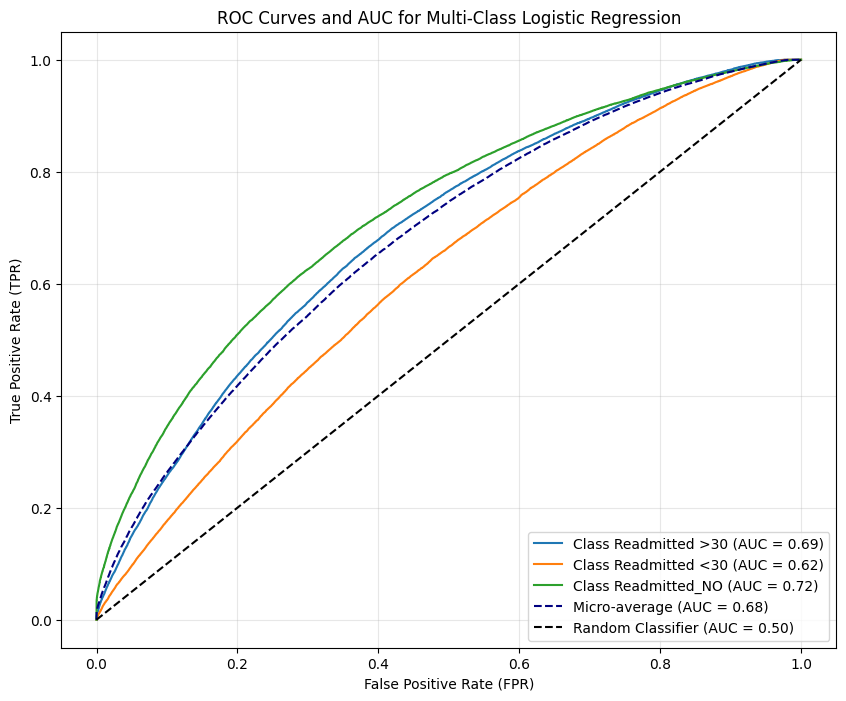

In [17]:
# Step 5: ROC and AUC

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np

# Binarize the target labels (required for multi-class ROC)
class_names = ['Readmitted >30', 'Readmitted <30', 'Readmitted_NO']

y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
n_classes = y_train_binarized.shape[1]
y_pred_proba = logreg.predict_proba(X_train_selected)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for Multi-Class Logistic Regression")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

Although this model doesn't overfit, it doesn't have a great performance thus we wouldn't be tuning its hyperparameters to achieve a better accuracy

## 2. LightGBM

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.118410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 51001
[LightGBM] [Info] Number of data points in the train set: 118452, number of used features: 586
[LightGBM] [Info] Start training from score -1.102037
[LightGBM] [Info] Start training from score -1.096083
[LightGBM] [Info] Start training from score -1.097726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

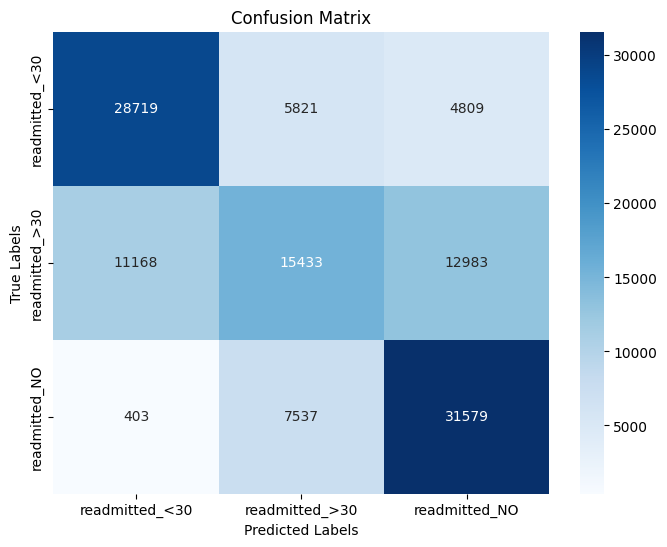

In [18]:
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Train the LightBGM model
lgbm_model = lgb.LGBMClassifier(
        objective='multiclass',
        num_class=len(np.unique(y_train)),
        random_state=42,
        n_estimators=100,
        max_depth=4,
    )
lgbm_model.fit(X_train, y_train)

# Step 2: Make predictions
y_train_pred = lgbm_model.predict(X_train)
y_val_pred = lgbm_model.predict(X_val)

# Step 3: Evaluate the model
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
accuracy_diff = train_accuracy - val_accuracy

print(f"\nModel Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Accuracy Difference (Training - Validation): {accuracy_diff:.4f}")
# Classification Report
print("Classification Report:\n")
print(classification_report(y_train, y_train_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"], yticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

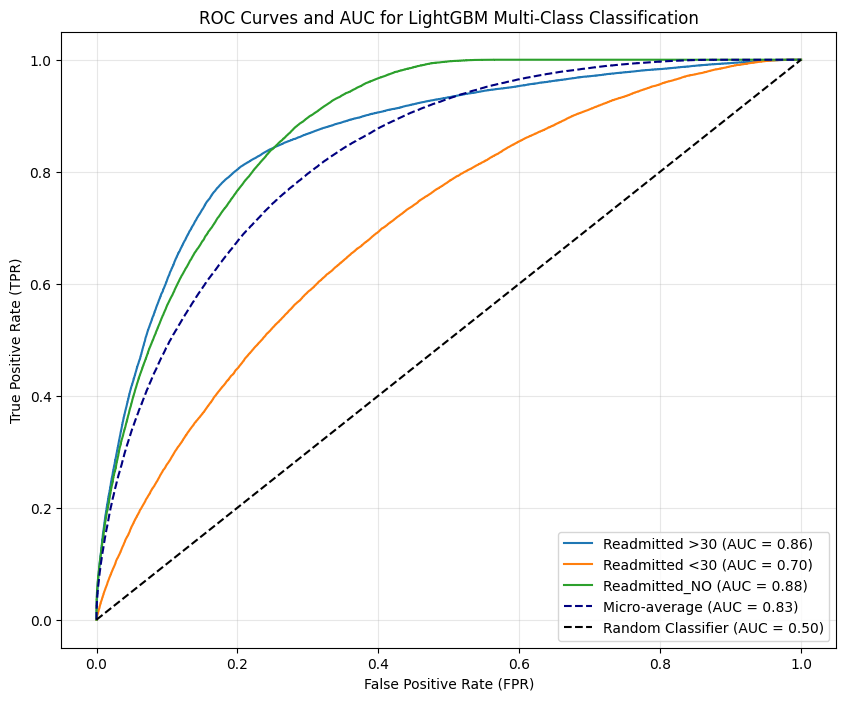

In [19]:
# Step 5: ROC and AUC

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the target labels
class_names = ['Readmitted >30', 'Readmitted <30', 'Readmitted_NO']
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
n_classes = y_train_binarized.shape[1]

# Get probability predictions
y_pred_proba = lgbm_model.predict_proba(X_train)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for LightGBM Multi-Class Classification")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

This model has no sign of overfitting and performs well, we will tune its hyperparameters to further enhance its performance.

---

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 47600
[LightGBM] [Info] Number of data points in the train set: 106606, number of used features: 572
[LightGBM] [Info] Start training from score -1.103276
[LightGBM] [Info] Start training from score -1.095391
[LightGBM] [Info] Start training from score -1.097187
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

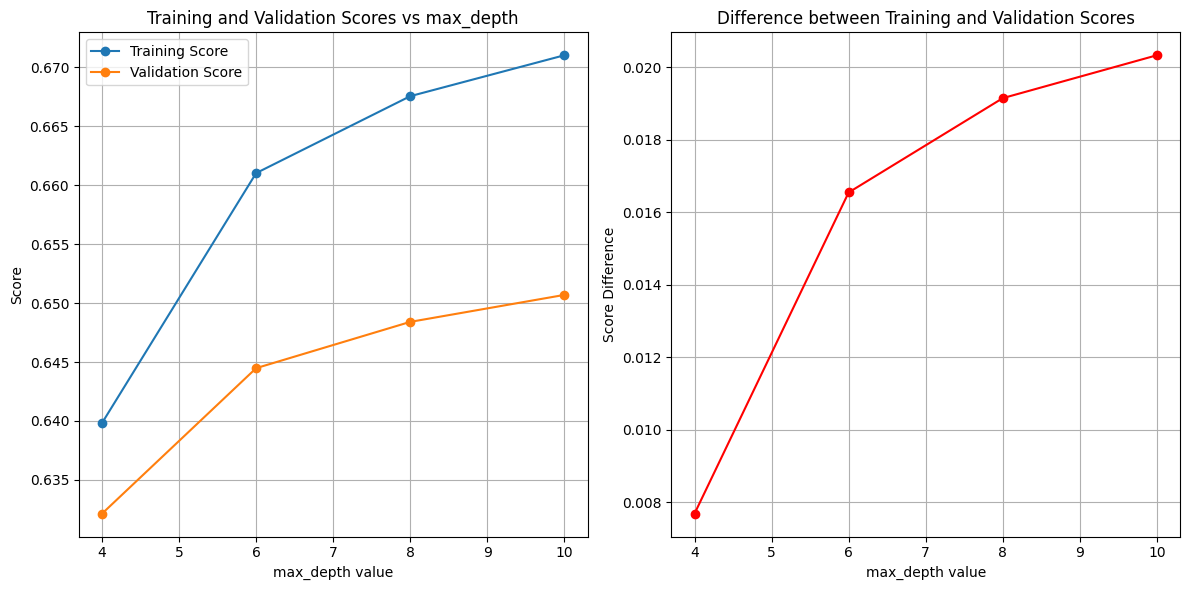

In [20]:
import lightgbm as lgb
from sklearn.model_selection import KFold, cross_validate
import matplotlib.pyplot as plt
import numpy as np

# Range of max_depth values to try
max_depth = [4, 6, 8, 10]  # You can modify this list
results = {}

for depth in max_depth:
    # Train LGBM model with different max_depth
    lgbm_model = lgb.LGBMClassifier(
        objective='multiclass',
        num_class=len(np.unique(y_train)),
        random_state=42,
        n_estimators=100,
        max_depth=depth,
        learning_rate=0.1,
        n_jobs=-1
    )
    
    # Setup cross-validation
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    
    # Get both training and validation scores
    cv_results = cross_validate(lgbm_model, X_train, y_train, 
                             cv=kf, 
                             scoring='accuracy',
                             return_train_score=True)
    
    difference = cv_results['train_score'].mean() - cv_results['test_score'].mean()
    
    # Store results for this depth value
    results[depth] = {
        'train_score': cv_results['train_score'].mean(),
        'train_std': cv_results['train_score'].std() * 2,
        'test_score': cv_results['test_score'].mean(),
        'test_std': cv_results['test_score'].std() * 2,
        'difference': difference
    }
    
    # Print results for each depth
    print(f"\nResults for max_depth={depth}:")
    print(f"Mean Training Score: {cv_results['train_score'].mean():.3f} (+/- {cv_results['train_score'].std() * 2:.3f})")
    print(f"Mean Validation Score: {cv_results['test_score'].mean():.3f} (+/- {cv_results['test_score'].std() * 2:.3f})")
    print(f"Score difference: {difference:.3f}")

# Plot results
plt.figure(figsize=(12, 6))
train_scores = [results[d]['train_score'] for d in max_depth]
test_scores = [results[d]['test_score'] for d in max_depth]
differences = [results[d]['difference'] for d in max_depth]

# Plot training and validation scores
plt.subplot(1, 2, 1)
plt.plot(max_depth, train_scores, marker='o', label='Training Score')
plt.plot(max_depth, test_scores, marker='o', label='Validation Score')
plt.xlabel('max_depth value')
plt.ylabel('Score')
plt.title('Training and Validation Scores vs max_depth')
plt.legend()
plt.grid(True)

# Plot differences
plt.subplot(1, 2, 2)
plt.plot(max_depth, differences, marker='o', color='red')
plt.xlabel('max_depth value')
plt.ylabel('Score Difference')
plt.title('Difference between Training and Validation Scores')
plt.grid(True)

plt.tight_layout()
plt.show()

Since the difference between training and validation accuracy is small even when the depth is 10, we would evaluate the model again using this value.

---

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 51001
[LightGBM] [Info] Number of data points in the train set: 118452, number of used features: 586
[LightGBM] [Info] Start training from score -1.102037
[LightGBM] [Info] Start training from score -1.096083
[LightGBM] [Info] Start training from score -1.097726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

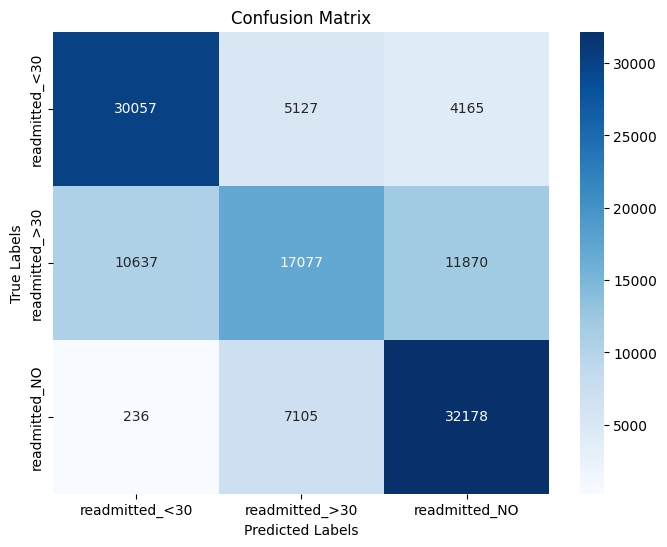

In [21]:
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Train the LightBGM model
lgbm_model = lgb.LGBMClassifier(
        objective='multiclass',
        num_class=len(np.unique(y_train)),
        random_state=42,
        n_estimators=100,
        max_depth=10,
    )
lgbm_model.fit(X_train, y_train)

# Step 2: Make predictions
y_train_pred = lgbm_model.predict(X_train)
y_val_pred = lgbm_model.predict(X_val)

# Step 3: Evaluate the model
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
accuracy_diff = train_accuracy - val_accuracy

print(f"\nModel Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Accuracy Difference (Training - Validation): {accuracy_diff:.4f}")
# Classification Report
print("Classification Report:\n")
print(classification_report(y_train, y_train_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"], yticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

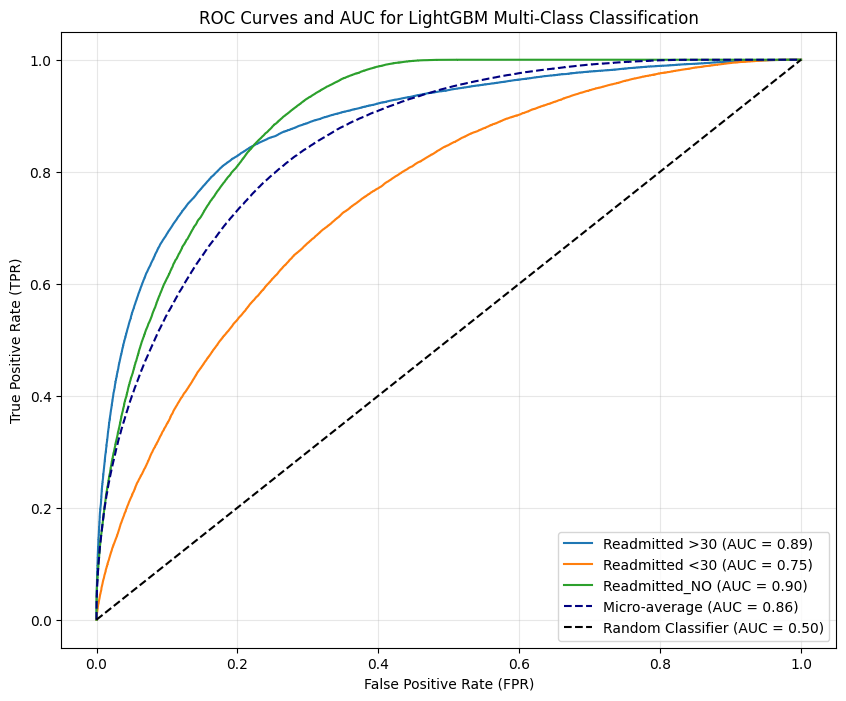

In [22]:
# Step 5: ROC and AUC

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the target labels
class_names = ['Readmitted >30', 'Readmitted <30', 'Readmitted_NO']
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
n_classes = y_train_binarized.shape[1]

# Get probability predictions
y_pred_proba = lgbm_model.predict_proba(X_train)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for LightGBM Multi-Class Classification")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

## 3. KNN Classifier



Model Performance:
Training Accuracy: 0.7156
Validation Accuracy: 0.6170
Accuracy Difference (Training - Validation): 0.0986
Classification Report:

                precision    recall  f1-score   support

readmitted_<30       0.68      0.99      0.80     39349
readmitted_>30       0.70      0.76      0.73     39584
 readmitted_NO       0.86      0.40      0.55     39519

      accuracy                           0.72    118452
     macro avg       0.75      0.72      0.69    118452
  weighted avg       0.75      0.72      0.69    118452



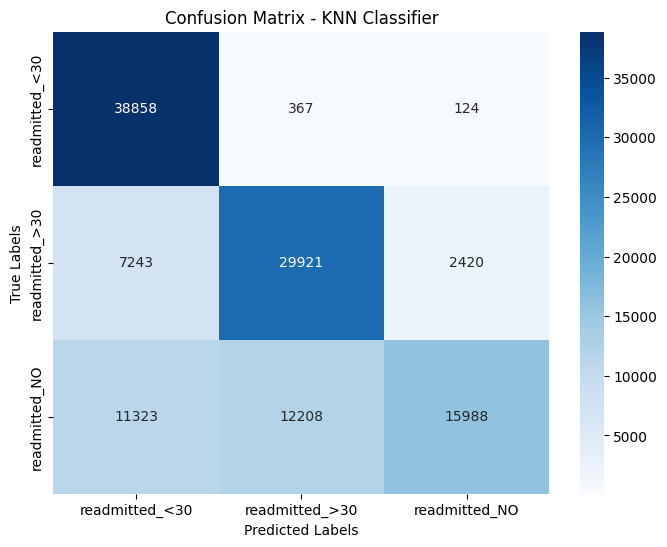

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Train KNN model
knn_model = KNeighborsClassifier(
    n_neighbors=5,  # You can adjust this parameter
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=2,  # Euclidean distance
    metric='minkowski',
)
knn_model.fit(X_train, y_train)

# Make predictions
y_train_pred = knn_model.predict(X_train)
y_val_pred = knn_model.predict(X_val)


train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
accuracy_diff = train_accuracy - val_accuracy

print(f"\nModel Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Accuracy Difference (Training - Validation): {accuracy_diff:.4f}")
# Print Classification Report
print("Classification Report:\n")
print(classification_report(y_train, y_train_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"],
            yticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"])
plt.title("Confusion Matrix - KNN Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

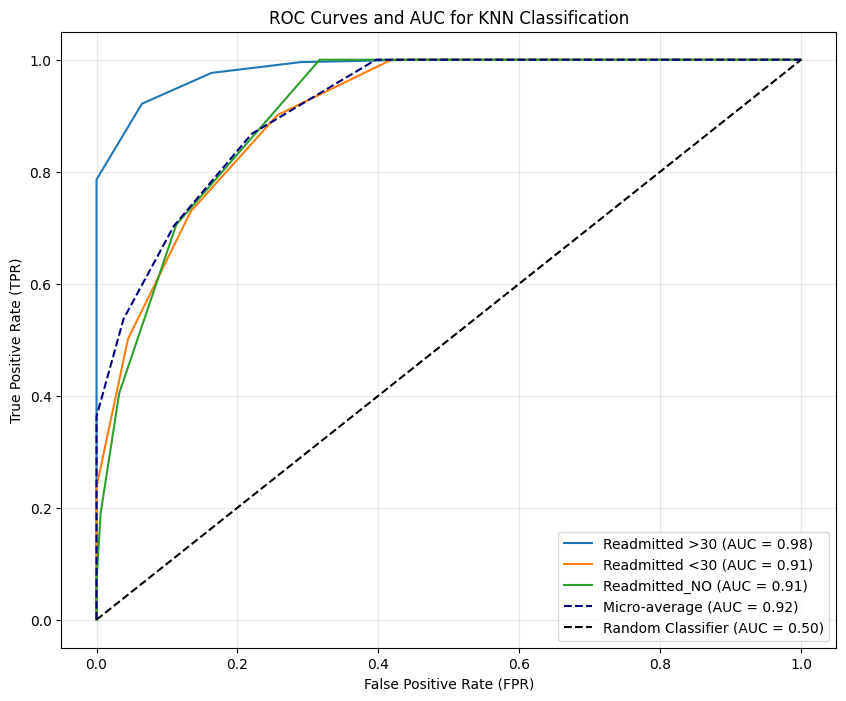

In [24]:
# Step 5: ROC and AUC

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the target labels
class_names = ['Readmitted >30', 'Readmitted <30', 'Readmitted_NO']
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
n_classes = y_train_binarized.shape[1]

# Get probability predictions
y_pred_proba = knn_model.predict_proba(X_train)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for KNN Classification")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

This models performs well on the training set, but slightly worse on the validation set, suggesting that overfitting might occur. Therefore, we are going to tune its hyperparameters to strike a balance between its performance and generalization.

---


Results for k=3:
Mean Training Score: 0.793 (+/- 0.001)
Mean Validation Score: 0.641 (+/- 0.010)
Score difference: 0.152

Results for k=4:
Mean Training Score: 0.719 (+/- 0.001)
Mean Validation Score: 0.613 (+/- 0.009)
Score difference: 0.107

Results for k=5:
Mean Training Score: 0.707 (+/- 0.001)
Mean Validation Score: 0.601 (+/- 0.010)
Score difference: 0.106

Results for k=6:
Mean Training Score: 0.670 (+/- 0.001)
Mean Validation Score: 0.580 (+/- 0.010)
Score difference: 0.090


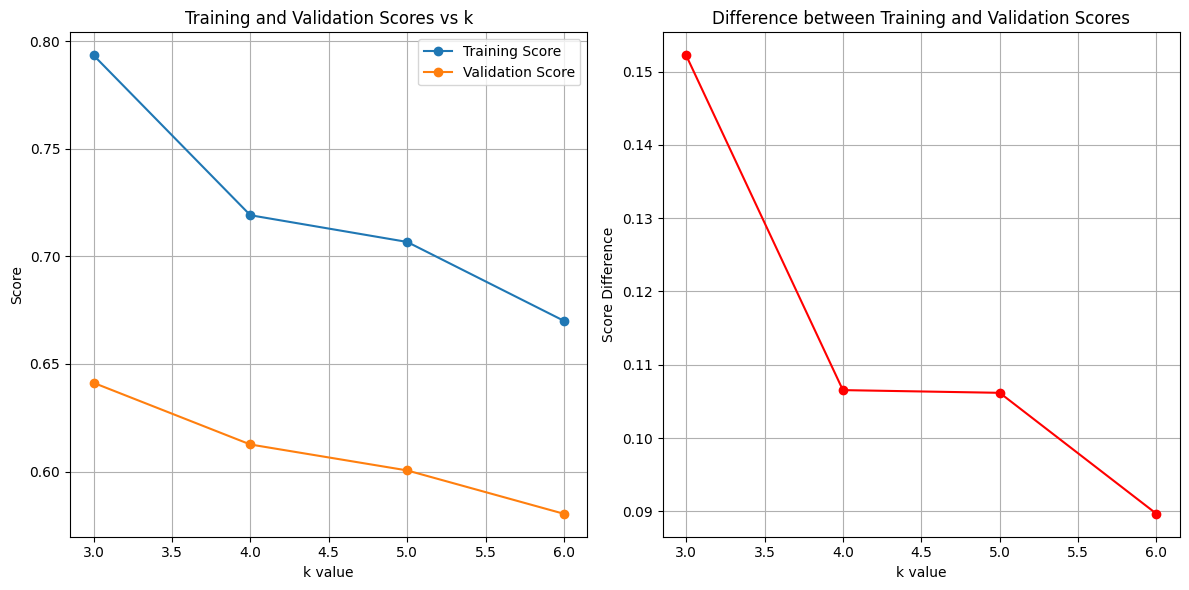

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_validate
import matplotlib.pyplot as plt
import numpy as np

# Range of k values to try
k_values = [3, 4, 5, 6]  # You can modify this list
results = {}

for k in k_values:
    # Train KNN model with different k
    knn_model = KNeighborsClassifier(
        n_neighbors=k,
        weights='uniform',
        algorithm='auto',
        leaf_size=30,
        p=2,
        metric='minkowski',
    )
    
    # Setup cross-validation
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    
    # Get both training and validation scores
    cv_results = cross_validate(knn_model, X_train, y_train, 
                             cv=kf, 
                             scoring='accuracy',
                             return_train_score=True)
    
    difference = cv_results['train_score'].mean() - cv_results['test_score'].mean()
    
    # Store results for this k value
    results[k] = {
        'train_score': cv_results['train_score'].mean(),
        'train_std': cv_results['train_score'].std() * 2,
        'test_score': cv_results['test_score'].mean(),
        'test_std': cv_results['test_score'].std() * 2,
        'difference': difference
    }
    
    # Print results for each k
    print(f"\nResults for k={k}:")
    print(f"Mean Training Score: {cv_results['train_score'].mean():.3f} (+/- {cv_results['train_score'].std() * 2:.3f})")
    print(f"Mean Validation Score: {cv_results['test_score'].mean():.3f} (+/- {cv_results['test_score'].std() * 2:.3f})")
    print(f"Score difference: {difference:.3f}")

# Plot results
plt.figure(figsize=(12, 6))
train_scores = [results[k]['train_score'] for k in k_values]
test_scores = [results[k]['test_score'] for k in k_values]
differences = [results[k]['difference'] for k in k_values]

# Plot training and validation scores
plt.subplot(1, 2, 1)
plt.plot(k_values, train_scores, marker='o', label='Training Score')
plt.plot(k_values, test_scores, marker='o', label='Validation Score')
plt.xlabel('k value')
plt.ylabel('Score')
plt.title('Training and Validation Scores vs k')
plt.legend()
plt.grid(True)

# Plot differences
plt.subplot(1, 2, 2)
plt.plot(k_values, differences, marker='o', color='red')
plt.xlabel('k value')
plt.ylabel('Score Difference')
plt.title('Difference between Training and Validation Scores')
plt.grid(True)

plt.tight_layout()
plt.show()


After conducting k-fold cross validation, we would pick 4 as our k value as it could strike a better balance between accuracy and generalization. 

---
Therefore, we would evaluate the model again but using 4 as our k value.


Model Performance:
Training Accuracy: 0.7264
Validation Accuracy: 0.6280
Accuracy Difference (Training - Validation): 0.0984
Classification Report:

                precision    recall  f1-score   support

readmitted_<30       0.71      0.99      0.83     39349
readmitted_>30       0.68      0.80      0.74     39584
 readmitted_NO       0.90      0.38      0.54     39519

      accuracy                           0.73    118452
     macro avg       0.76      0.73      0.70    118452
  weighted avg       0.76      0.73      0.70    118452



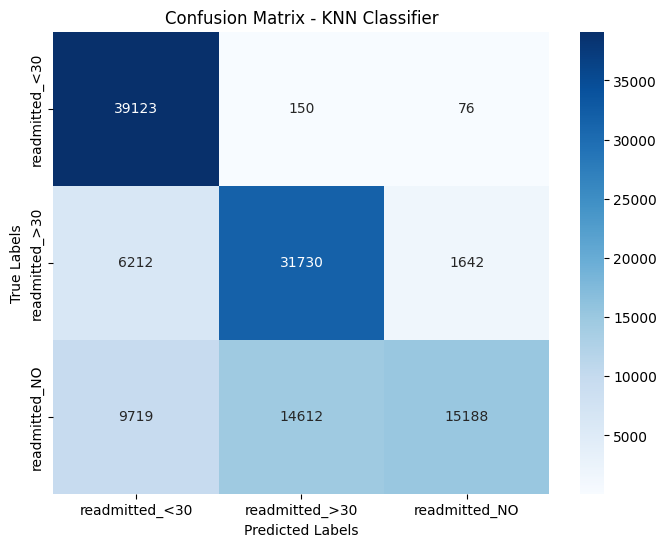

In [30]:
# Train KNN model
knn_model = KNeighborsClassifier(
    n_neighbors=4,  # You can adjust this parameter
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=2,  # Euclidean distance
    metric='minkowski',
)
knn_model.fit(X_train, y_train)

# Make predictions
y_train_pred = knn_model.predict(X_train)
y_val_pred = knn_model.predict(X_val)

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
accuracy_diff = train_accuracy - val_accuracy

print(f"\nModel Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Accuracy Difference (Training - Validation): {accuracy_diff:.4f}")
# Print Classification Report
print("Classification Report:\n")
print(classification_report(y_train, y_train_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"],
            yticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"])
plt.title("Confusion Matrix - KNN Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

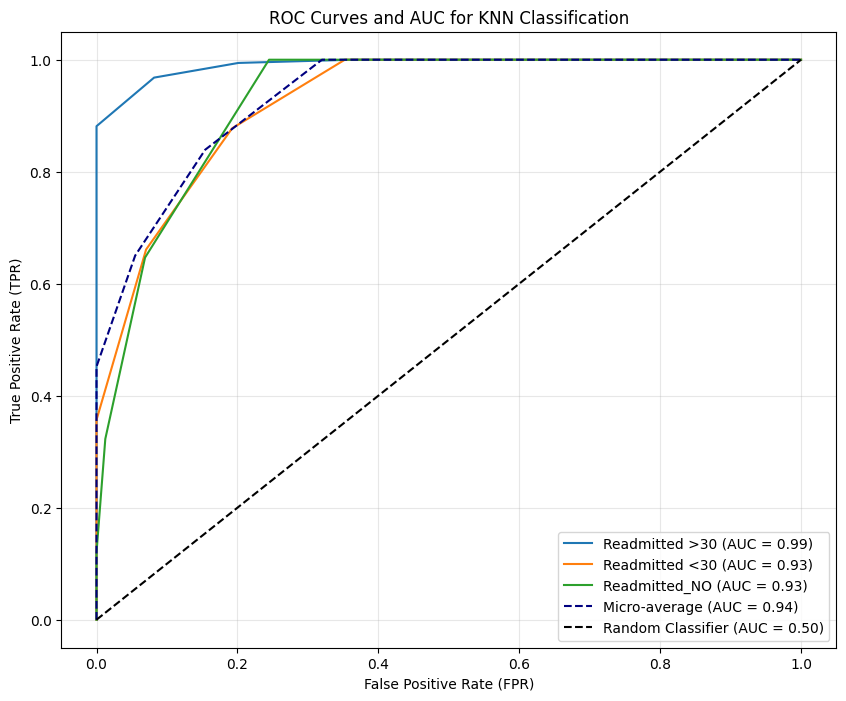

In [31]:
# Step 5: ROC and AUC

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the target labels
class_names = ['Readmitted >30', 'Readmitted <30', 'Readmitted_NO']
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
n_classes = y_train_binarized.shape[1]

# Get probability predictions
y_pred_proba = knn_model.predict_proba(X_train)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for KNN Classification")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

## 4. XGBoost

Training XGBoost model...

Model Performance:
Training Accuracy: 0.7868
Validation Accuracy: 0.6778
Accuracy Difference (Training - Validation): 0.1089
Classification Report:

                precision    recall  f1-score   support

readmitted_<30       0.85      0.82      0.84     39349
readmitted_>30       0.76      0.66      0.70     39584
 readmitted_NO       0.75      0.88      0.81     39519

      accuracy                           0.79    118452
     macro avg       0.79      0.79      0.78    118452
  weighted avg       0.79      0.79      0.78    118452



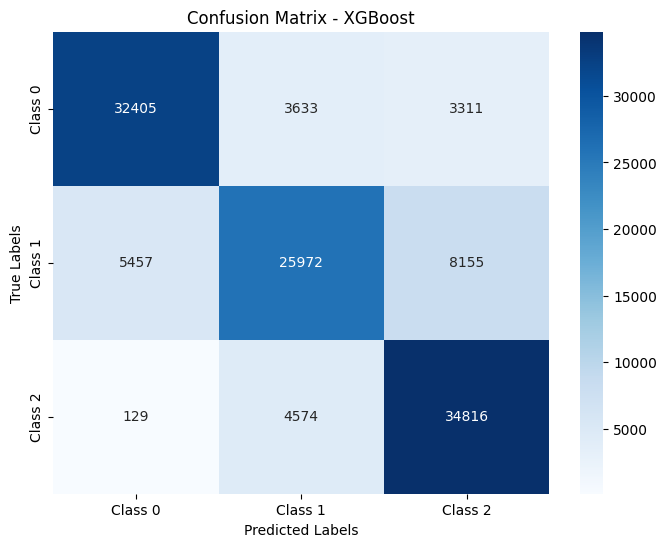

In [26]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Train XGBoost model
print("Training XGBoost model...")
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',  
    num_class=3,              
    eval_metric='mlogloss',     
    random_state=42,
    max_depth=10,
)

xgb_model.fit(X_train, y_train)

# Make predictions
y_train_pred = xgb_model.predict(X_train)
y_val_pred = xgb_model.predict(X_val)

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
accuracy_diff = train_accuracy - val_accuracy

print(f"\nModel Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Accuracy Difference (Training - Validation): {accuracy_diff:.4f}")
# Print Classification Report
print("Classification Report:\n")
print(classification_report(y_train, y_train_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Step 4: Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


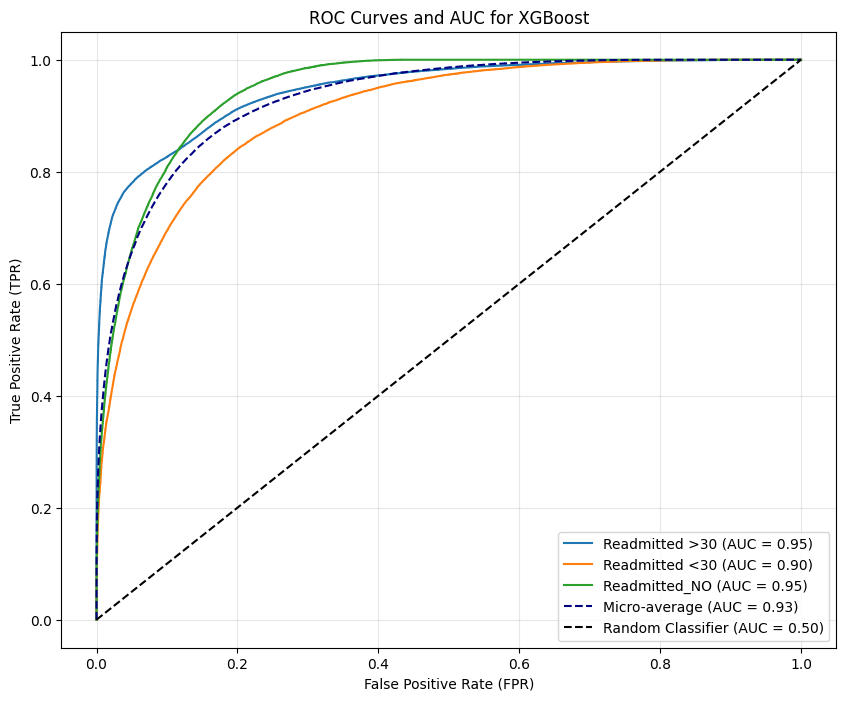

In [27]:
# Step 5: ROC and AUC

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the target labels
class_names = ['Readmitted >30', 'Readmitted <30', 'Readmitted_NO']
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
n_classes = y_train_binarized.shape[1]

# Get probability predictions
y_pred_proba = xgb_model.predict_proba(X_train)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for XGBoost")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

We could tell the XGBoost model performs very well on the training set, yet the overfitting problem is quite serious for this model, so we would try tuning the hyperarameters to lower the difference between training and validation accuracies while maintaining its quality performance.

---


Results for depth=5:
Mean Training Score: 0.677 (+/- 0.002)
Mean Validation Score: 0.650 (+/- 0.010)
Score difference: 0.027

Results for depth=8:
Mean Training Score: 0.741 (+/- 0.003)
Mean Validation Score: 0.666 (+/- 0.009)
Score difference: 0.075

Results for depth=10:
Mean Training Score: 0.794 (+/- 0.004)
Mean Validation Score: 0.674 (+/- 0.008)
Score difference: 0.120

Results for depth=12:
Mean Training Score: 0.851 (+/- 0.004)
Mean Validation Score: 0.682 (+/- 0.010)
Score difference: 0.169


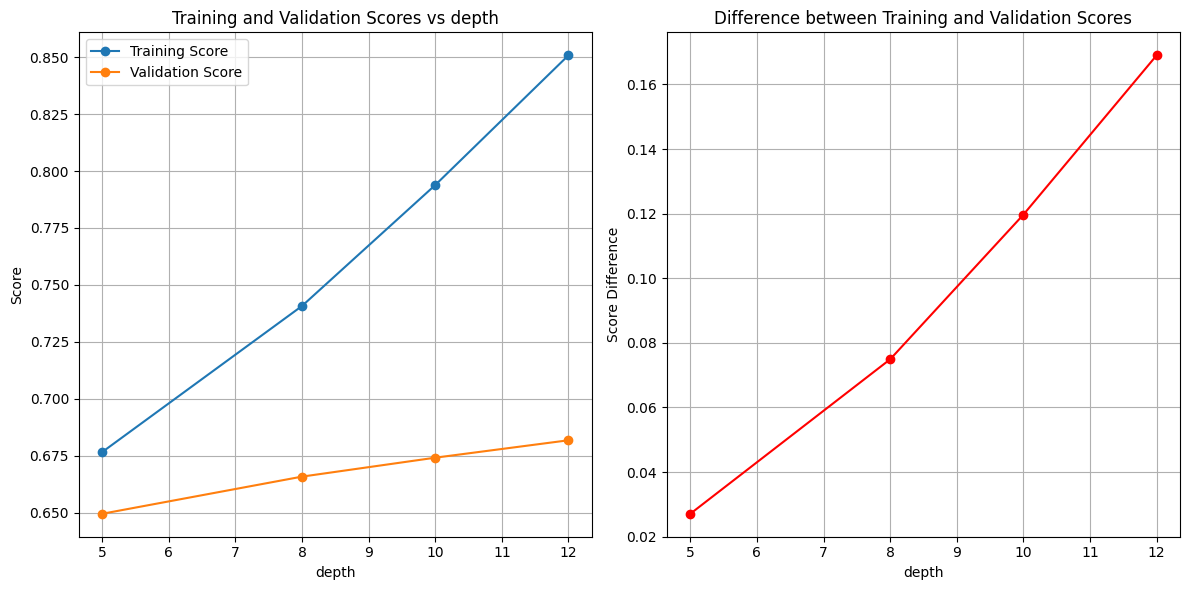

In [32]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_validate
import matplotlib.pyplot as plt
import numpy as np

# Range of k values to try
max_depth = [5, 8, 10, 12]  # You can modify this list
results = {}

for depth in max_depth:
    # Train XGBoost model with different depths
    xgb_model = xgb.XGBClassifier(
        objective='multi:softprob',  
        num_class=3,              
        eval_metric='mlogloss',     
        random_state=42,
        max_depth=depth
    )
    
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    
    cv_results = cross_validate(xgb_model, X_train, y_train, 
                             cv=kf, 
                             scoring='accuracy',
                             return_train_score=True)
    
    difference = cv_results['train_score'].mean() - cv_results['test_score'].mean()
    
    # Store results for this depth value
    results[depth] = {
        'train_score': cv_results['train_score'].mean(),
        'train_std': cv_results['train_score'].std() * 2,
        'test_score': cv_results['test_score'].mean(),
        'test_std': cv_results['test_score'].std() * 2,
        'difference': difference
    }
    
    # Print results for each depth
    print(f"\nResults for depth={depth}:")
    print(f"Mean Training Score: {cv_results['train_score'].mean():.3f} (+/- {cv_results['train_score'].std() * 2:.3f})")
    print(f"Mean Validation Score: {cv_results['test_score'].mean():.3f} (+/- {cv_results['test_score'].std() * 2:.3f})")
    print(f"Score difference: {difference:.3f}")

# Plot results
plt.figure(figsize=(12, 6))
train_scores = [results[depth]['train_score'] for depth in max_depth]
test_scores = [results[depth]['test_score'] for depth in max_depth]
differences = [results[depth]['difference'] for depth in max_depth]

# Plot training and validation scores
plt.subplot(1, 2, 1)
plt.plot(max_depth, train_scores, marker='o', label='Training Score')
plt.plot(max_depth, test_scores, marker='o', label='Validation Score')
plt.xlabel('depth')
plt.ylabel('Score')
plt.title('Training and Validation Scores vs depth')
plt.legend()
plt.grid(True)

# Plot differences
plt.subplot(1, 2, 2)
plt.plot(max_depth, differences, marker='o', color='red')
plt.xlabel('depth')
plt.ylabel('Score Difference')
plt.title('Difference between Training and Validation Scores')
plt.grid(True)

plt.tight_layout()
plt.show()


After tuning its hyperparameter and referring to the graph, we would choose 9 as the depth as it reduces the overfitting problem while maintaining an acceptable performance

---
Therefore, we would evaluate the model again using the new hyperparameter

Training XGBoost model...

Model Performance:
Training Accuracy: 0.7609
Validation Accuracy: 0.6735
Accuracy Difference (Training - Validation): 0.0874
Classification Report:

                precision    recall  f1-score   support

readmitted_<30       0.83      0.81      0.82     39349
readmitted_>30       0.72      0.61      0.66     39584
 readmitted_NO       0.73      0.86      0.79     39519

      accuracy                           0.76    118452
     macro avg       0.76      0.76      0.76    118452
  weighted avg       0.76      0.76      0.76    118452



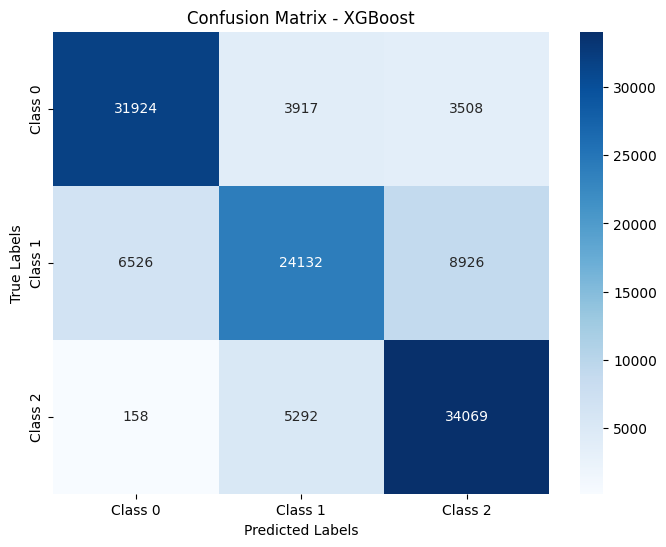

In [34]:
import xgboost as xgb

# Step 1: Train XGBoost model
print("Training XGBoost model...")
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',  
    num_class=3,              
    eval_metric='mlogloss',     
    random_state=42,
    max_depth=9,
)

xgb_model.fit(X_train, y_train)

# Make predictions
y_train_pred = xgb_model.predict(X_train)
y_val_pred = xgb_model.predict(X_val)

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
accuracy_diff = train_accuracy - val_accuracy

print(f"\nModel Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Accuracy Difference (Training - Validation): {accuracy_diff:.4f}")
# Print Classification Report
print("Classification Report:\n")
print(classification_report(y_train, y_train_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Step 4: Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

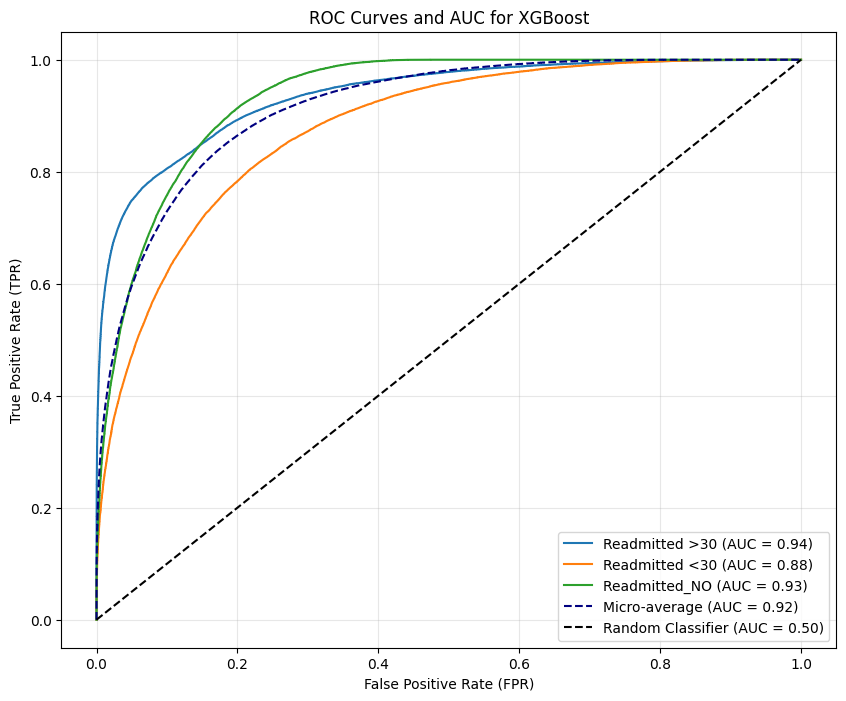

In [35]:
# Step 5: ROC and AUC

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the target labels
class_names = ['Readmitted >30', 'Readmitted <30', 'Readmitted_NO']
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
n_classes = y_train_binarized.shape[1]

# Get probability predictions
y_pred_proba = xgb_model.predict_proba(X_train)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for XGBoost")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

## 5. Support Vector Machine

Training Support Vector Machine model...

Model Performance:
Training Accuracy: 0.4951
Validation Accuracy: 0.4914
Accuracy Difference (Training - Validation): 0.0037

Classification Report:
                precision    recall  f1-score   support

readmitted_<30       0.50      0.63      0.55     39349
readmitted_>30       0.52      0.14      0.21     39584
 readmitted_NO       0.49      0.73      0.58     39519

      accuracy                           0.50    118452
     macro avg       0.50      0.50      0.45    118452
  weighted avg       0.50      0.50      0.45    118452



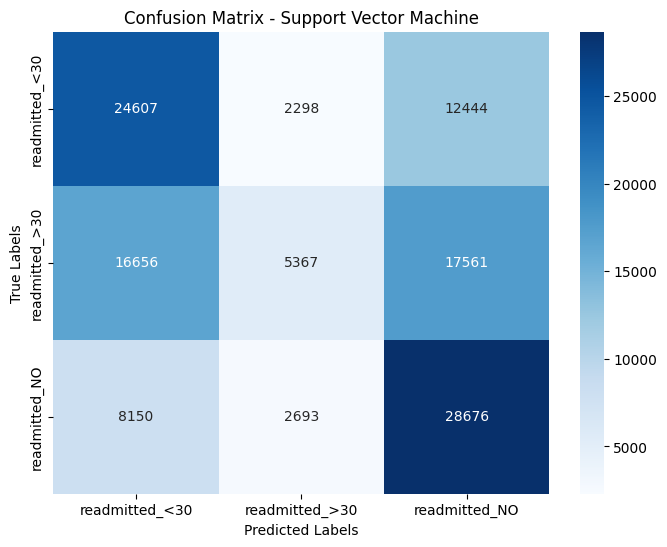

In [28]:
from sklearn.linear_model import SGDClassifier

# Step 1: Train Support Vector Machine model 
print("Training Support Vector Machine model...")
svm_model = SGDClassifier(
    loss='hinge',
    random_state=42,
    max_iter=1000,
    tol=0.0001,
    n_jobs=-1,
    
)

svm_model.fit(X_train, y_train)

# Make predictions
y_train_pred = svm_model.predict(X_train)
y_val_pred = svm_model.predict(X_val)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
accuracy_diff = train_accuracy - val_accuracy

print(f"\nModel Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Accuracy Difference (Training - Validation): {accuracy_diff:.4f}")

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Create and plot Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"], 
            yticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"])
plt.title("Confusion Matrix - Support Vector Machine")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

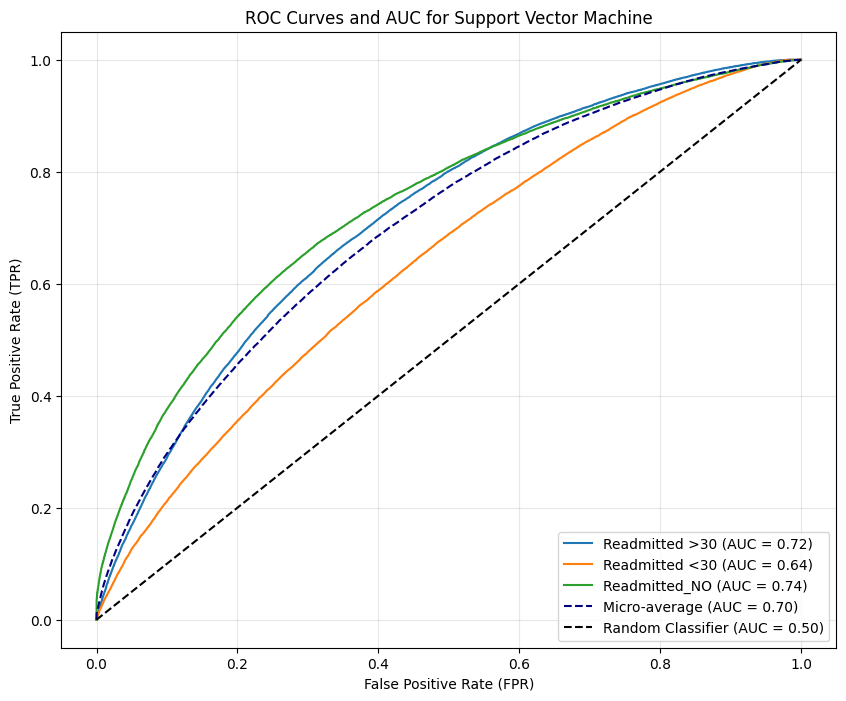

In [29]:
# Step 5: ROC and AUC

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import numpy as np

# Binarize the target labels
class_names = ['Readmitted >30', 'Readmitted <30', 'Readmitted_NO']
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
n_classes = y_train_binarized.shape[1]

# Calibrate the model so that we could get probability predictions
calibrated_svm = CalibratedClassifierCV(svm_model, cv=5)
calibrated_svm.fit(X_train, y_train)

# Get probability predictions
y_pred_proba = calibrated_svm.predict_proba(X_train)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for Support Vector Machine")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

We could conclude that this model has no overfitting problem, yet it has the worst performance by far, therefore we wouldn't be tuning its hyperparameters to improve its accuracy and would proceed to the next model

## 6. Random Forest

Training Random Forest model...

Model Performance:
Training Accuracy: 0.7636
Validation Accuracy: 0.6447
Accuracy Difference (Training - Validation): 0.1189

Classification Report:

              precision    recall  f1-score   support

     Class 0       0.79      0.86      0.82     39349
     Class 1       0.82      0.57      0.67     39584
     Class 2       0.70      0.87      0.78     39519

    accuracy                           0.76    118452
   macro avg       0.77      0.76      0.76    118452
weighted avg       0.77      0.76      0.76    118452



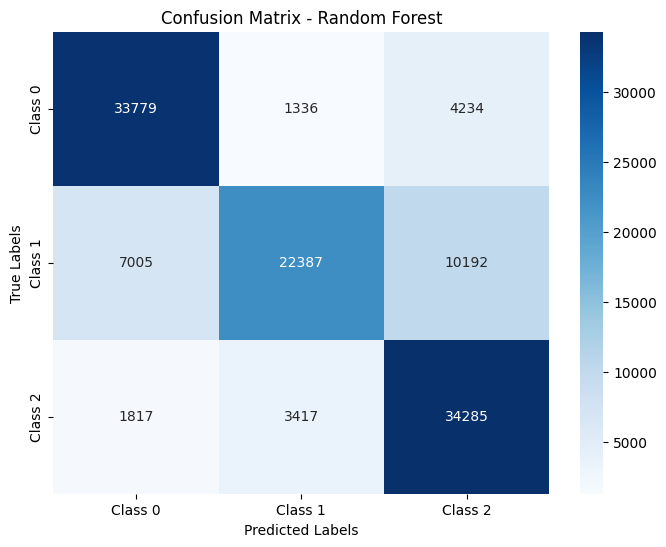

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Train Random Forest model
print("Training Random Forest model...")
rf_model = RandomForestClassifier(
    n_estimators=80,  
    random_state=42,     
    max_depth=20,      
    class_weight="balanced"  
)

rf_model.fit(X_train, y_train)

# Make predictions
y_train_pred = rf_model.predict(X_train)
y_val_pred = rf_model.predict(X_val)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
accuracy_diff = train_accuracy - val_accuracy

print(f"\nModel Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Accuracy Difference (Training - Validation): {accuracy_diff:.4f}")

# Step 3: Classification Report
print("\nClassification Report:\n")
print(classification_report(y_train, y_train_pred, target_names=["Class 0", "Class 1", "Class 2"]))

# Step 4: Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

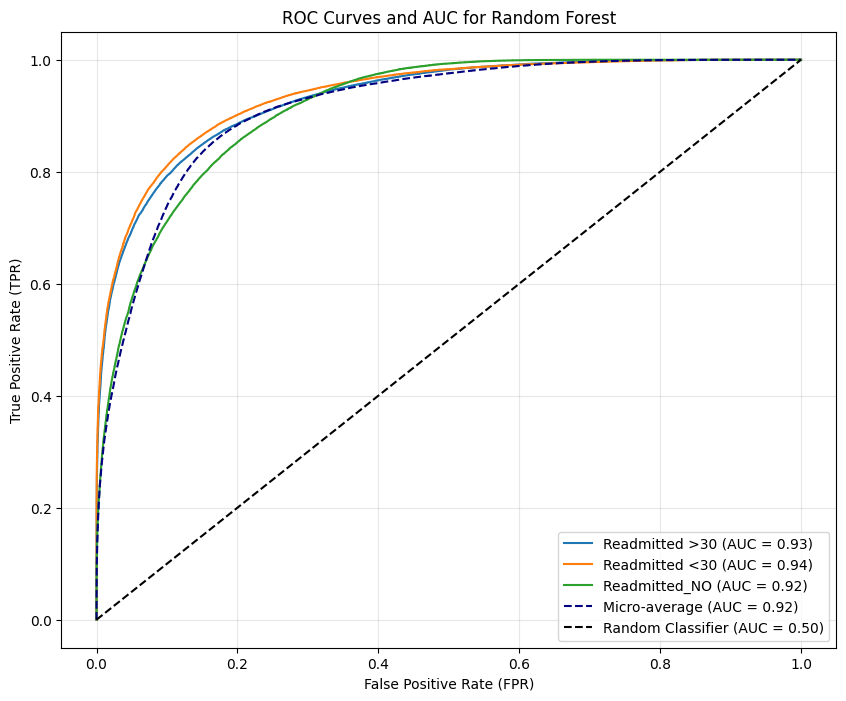

In [36]:
# Step 5: ROC and AUC

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the target labels
class_names = ['Readmitted >30', 'Readmitted <30', 'Readmitted_NO']
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
n_classes = y_train_binarized.shape[1]

# Get probability predictions
y_pred_proba = rf_model.predict_proba(X_train)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for Random Forest")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

This model is by far the best one regarding accuracy, yet it has the most serious overfitting problem, therefore we would have to tune its hyperparameters to lessen the overfitting issue

---


Results for depth=15:
Mean Training Score: 0.663 (+/- 0.011)
Mean Validation Score: 0.601 (+/- 0.015)
Score difference: 0.062

Results for depth=20:
Mean Training Score: 0.763 (+/- 0.008)
Mean Validation Score: 0.637 (+/- 0.010)
Score difference: 0.126

Results for depth=25:
Mean Training Score: 0.863 (+/- 0.004)
Mean Validation Score: 0.667 (+/- 0.010)
Score difference: 0.196

Results for depth=30:
Mean Training Score: 0.931 (+/- 0.004)
Mean Validation Score: 0.688 (+/- 0.010)
Score difference: 0.244


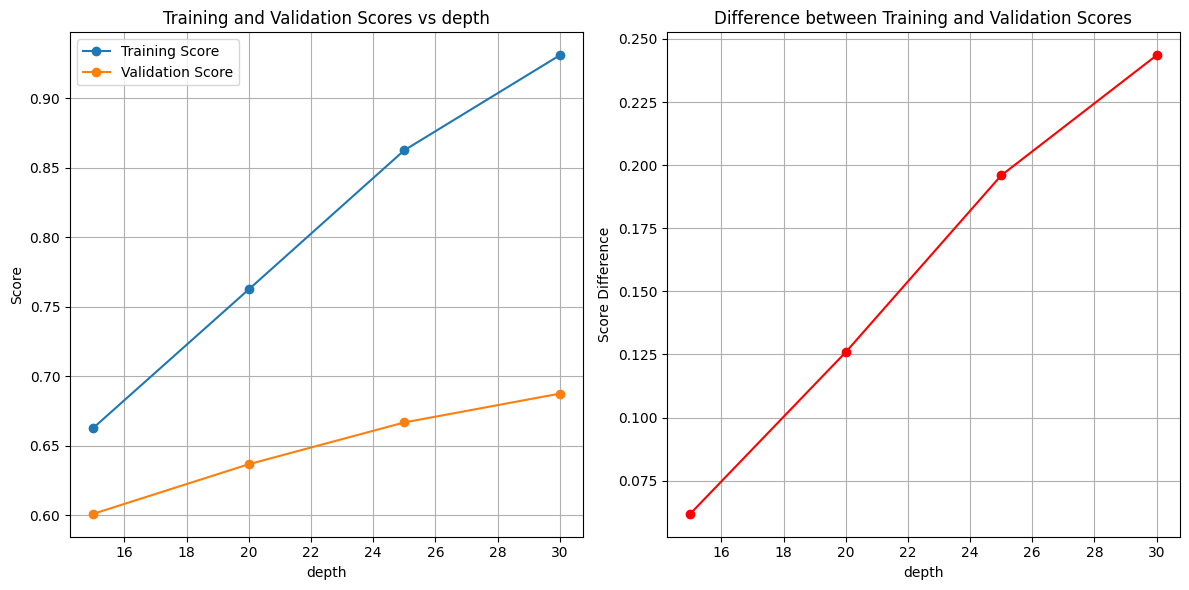

In [42]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_validate
import matplotlib.pyplot as plt
import numpy as np

# Range of k values to try
max_depth = [15, 20, 25, 30]  # You can modify this list
results = {}

for depth in max_depth:
    # Train random forest model with different depths
    rf_model = RandomForestClassifier(
        n_estimators=80,  
        random_state=42,     
        max_depth=depth,      
        class_weight="balanced"  
    )
    
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    
    cv_results = cross_validate(rf_model, X_train, y_train, 
                             cv=kf, 
                             scoring='accuracy',
                             return_train_score=True)
    
    difference = cv_results['train_score'].mean() - cv_results['test_score'].mean()
    
    # Store results for this depth value
    results[depth] = {
        'train_score': cv_results['train_score'].mean(),
        'train_std': cv_results['train_score'].std() * 2,
        'test_score': cv_results['test_score'].mean(),
        'test_std': cv_results['test_score'].std() * 2,
        'difference': difference
    }
    
    # Print results for each depth
    print(f"\nResults for depth={depth}:")
    print(f"Mean Training Score: {cv_results['train_score'].mean():.3f} (+/- {cv_results['train_score'].std() * 2:.3f})")
    print(f"Mean Validation Score: {cv_results['test_score'].mean():.3f} (+/- {cv_results['test_score'].std() * 2:.3f})")
    print(f"Score difference: {difference:.3f}")

# Plot results
plt.figure(figsize=(12, 6))
train_scores = [results[depth]['train_score'] for depth in max_depth]
test_scores = [results[depth]['test_score'] for depth in max_depth]
differences = [results[depth]['difference'] for depth in max_depth]

# Plot training and validation scores
plt.subplot(1, 2, 1)
plt.plot(max_depth, train_scores, marker='o', label='Training Score')
plt.plot(max_depth, test_scores, marker='o', label='Validation Score')
plt.xlabel('depth')
plt.ylabel('Score')
plt.title('Training and Validation Scores vs depth')
plt.legend()
plt.grid(True)

# Plot differences
plt.subplot(1, 2, 2)
plt.plot(max_depth, differences, marker='o', color='red')
plt.xlabel('depth')
plt.ylabel('Score Difference')
plt.title('Difference between Training and Validation Scores')
plt.grid(True)

plt.tight_layout()
plt.show() 


To achieve a balance between regularisation and accuracy and by referring to the graph, we would choose 18 as its max depth

---
We would evaluate the model again using 18 as the max depth

Training Random Forest model...

Model Performance:
Training Accuracy: 0.7191
Validation Accuracy: 0.6307
Accuracy Difference (Training - Validation): 0.0884

Classification Report:

              precision    recall  f1-score   support

     Class 0       0.74      0.83      0.78     39349
     Class 1       0.77      0.49      0.60     39584
     Class 2       0.67      0.84      0.75     39519

    accuracy                           0.72    118452
   macro avg       0.73      0.72      0.71    118452
weighted avg       0.73      0.72      0.71    118452



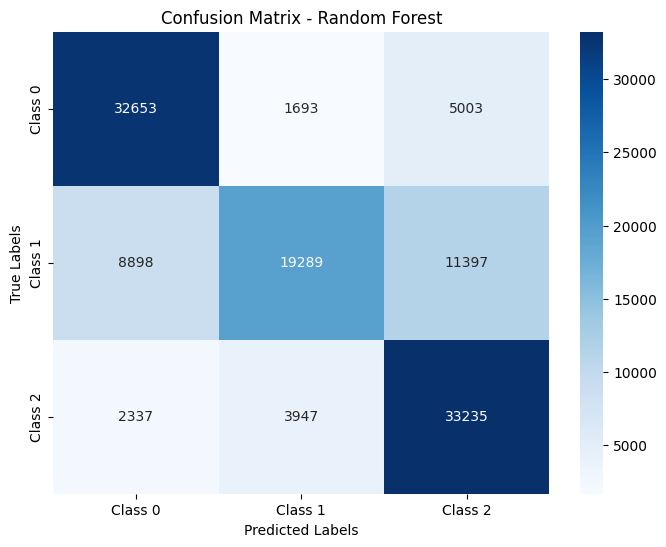

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Train Random Forest model
print("Training Random Forest model...")
rf_model = RandomForestClassifier(
    n_estimators=80,  
    random_state=42,     
    max_depth=18,      
    class_weight="balanced"  
)

rf_model.fit(X_train, y_train)

# Make predictions
y_train_pred = rf_model.predict(X_train)
y_val_pred = rf_model.predict(X_val)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
accuracy_diff = train_accuracy - val_accuracy

print(f"\nModel Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Accuracy Difference (Training - Validation): {accuracy_diff:.4f}")

# Step 3: Classification Report
print("\nClassification Report:\n")
print(classification_report(y_train, y_train_pred, target_names=["Class 0", "Class 1", "Class 2"]))

# Step 4: Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

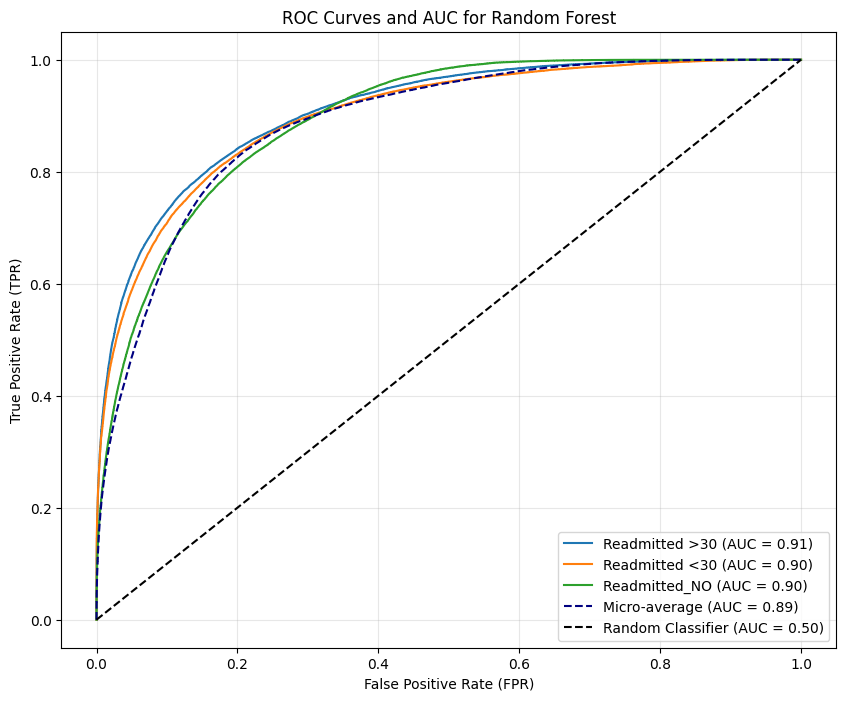

In [44]:
# Step 5: ROC and AUC

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the target labels
class_names = ['Readmitted >30', 'Readmitted <30', 'Readmitted_NO']
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
n_classes = y_train_binarized.shape[1]

# Get probability predictions
y_pred_proba = rf_model.predict_proba(X_train)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for Random Forest")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

---

## Final evaluation with test set

## 1. Logistic regression

Classification Report:

                precision    recall  f1-score   support

readmitted_<30       0.20      0.36      0.26      1112
readmitted_>30       0.47      0.38      0.42      3556
 readmitted_NO       0.67      0.65      0.66      5509

      accuracy                           0.52     10177
     macro avg       0.45      0.46      0.45     10177
  weighted avg       0.55      0.52      0.53     10177



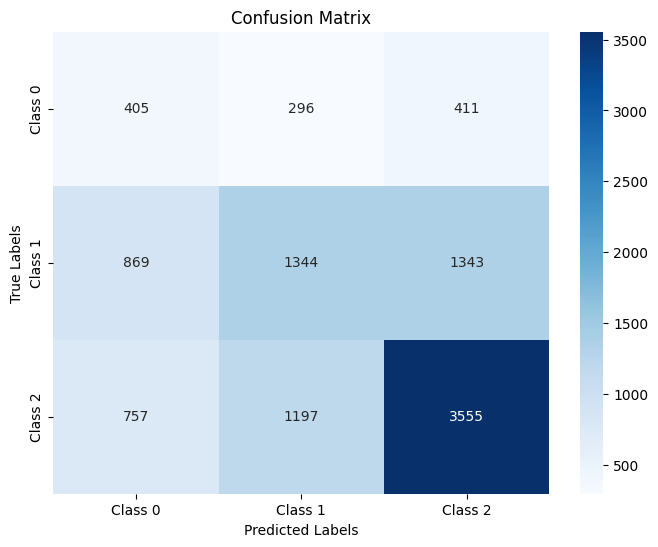

In [47]:
y_pred = logreg.predict(X_test_selected)


print("Classification Report:\n")
print(classification_report(y_test_, y_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Step 4: Confusion Matrix
conf_matrix = confusion_matrix(y_test_, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## 2. LightGBM

Classification Report:

                precision    recall  f1-score   support

readmitted_<30       0.46      0.05      0.10      1112
readmitted_>30       0.54      0.48      0.51      3556
 readmitted_NO       0.65      0.82      0.72      5509

      accuracy                           0.61     10177
     macro avg       0.55      0.45      0.44     10177
  weighted avg       0.59      0.61      0.58     10177



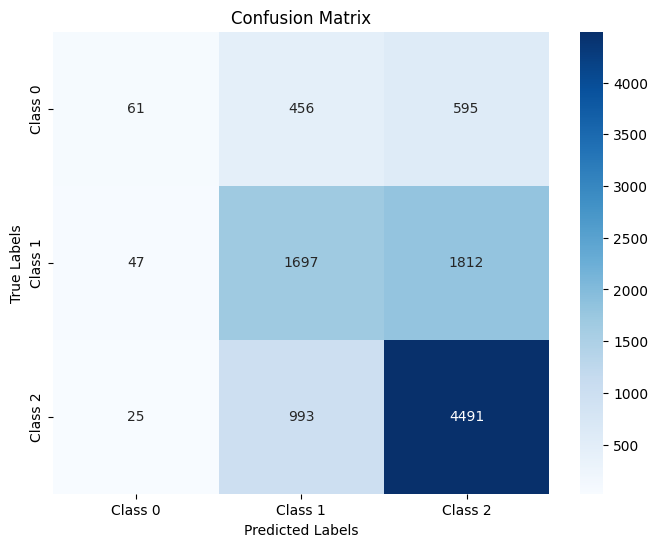

In [48]:
y_pred = lgbm_model.predict(X_test_)


print("Classification Report:\n")
print(classification_report(y_test_, y_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Step 4: Confusion Matrix
conf_matrix = confusion_matrix(y_test_, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## 3. KNN classifier

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Classification Report:

                precision    recall  f1-score   support

readmitted_<30       0.13      0.41      0.19      1112
readmitted_>30       0.37      0.49      0.42      3556
 readmitted_NO       0.64      0.23      0.33      5509

      accuracy                           0.34     10177
     macro avg       0.38      0.37      0.32     10177
  weighted avg       0.49      0.34      0.35     10177



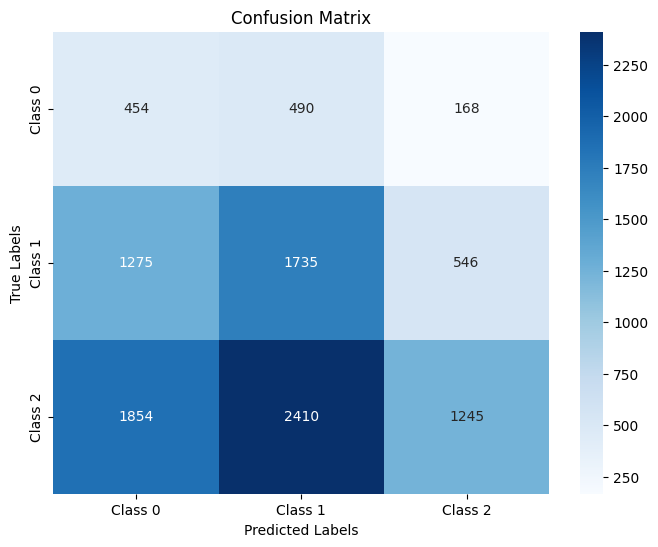

In [49]:
y_pred = knn_model.predict(X_test_)


print("Classification Report:\n")
print(classification_report(y_test_, y_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Step 4: Confusion Matrix
conf_matrix = confusion_matrix(y_test_, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## 4. XGBoost

Classification Report:

                precision    recall  f1-score   support

readmitted_<30       0.38      0.06      0.11      1112
readmitted_>30       0.52      0.48      0.50      3556
 readmitted_NO       0.65      0.80      0.72      5509

      accuracy                           0.61     10177
     macro avg       0.52      0.45      0.44     10177
  weighted avg       0.58      0.61      0.57     10177



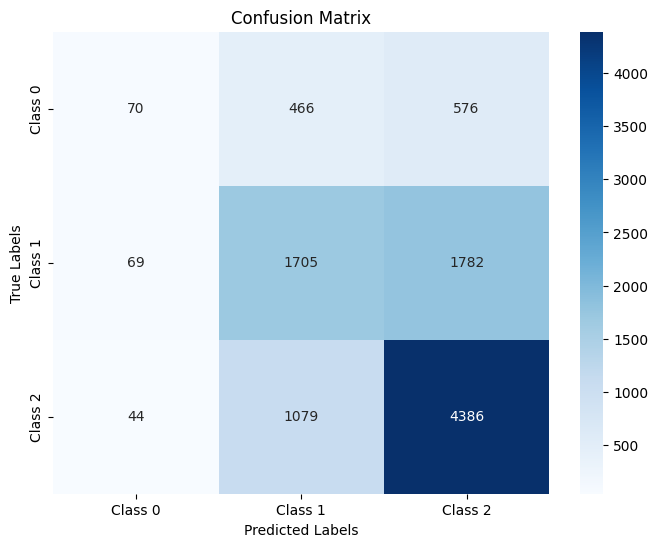

In [50]:
y_pred = xgb_model.predict(X_test_)


print("Classification Report:\n")
print(classification_report(y_test_, y_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Step 4: Confusion Matrix
conf_matrix = confusion_matrix(y_test_, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## 5. Support Vector Machine

Classification Report:

                precision    recall  f1-score   support

readmitted_<30       0.18      0.46      0.26      1112
readmitted_>30       0.48      0.14      0.22      3556
 readmitted_NO       0.64      0.73      0.68      5509

      accuracy                           0.50     10177
     macro avg       0.43      0.44      0.39     10177
  weighted avg       0.53      0.50      0.47     10177



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SGDClassifier was fitted without feature names
  warnings.warn(


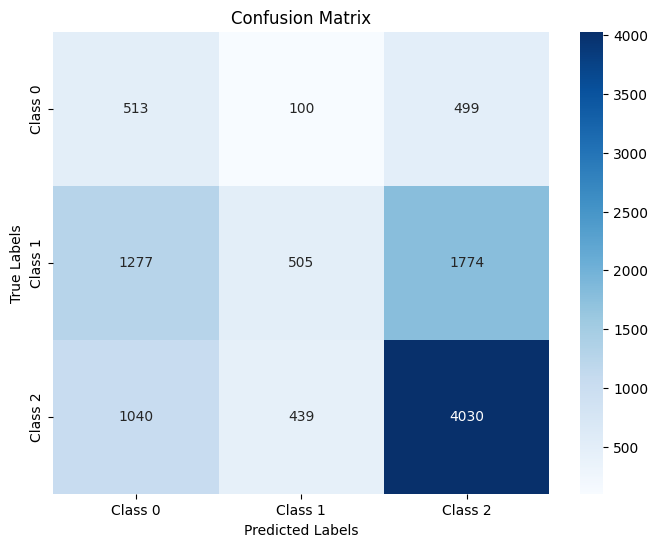

In [51]:
y_pred = svm_model.predict(X_test_)


print("Classification Report:\n")
print(classification_report(y_test_, y_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Step 4: Confusion Matrix
conf_matrix = confusion_matrix(y_test_, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## 6. Random forest

Classification Report:

                precision    recall  f1-score   support

readmitted_<30       0.26      0.16      0.20      1112
readmitted_>30       0.52      0.37      0.43      3556
 readmitted_NO       0.64      0.80      0.71      5509

      accuracy                           0.58     10177
     macro avg       0.47      0.45      0.45     10177
  weighted avg       0.55      0.58      0.56     10177



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


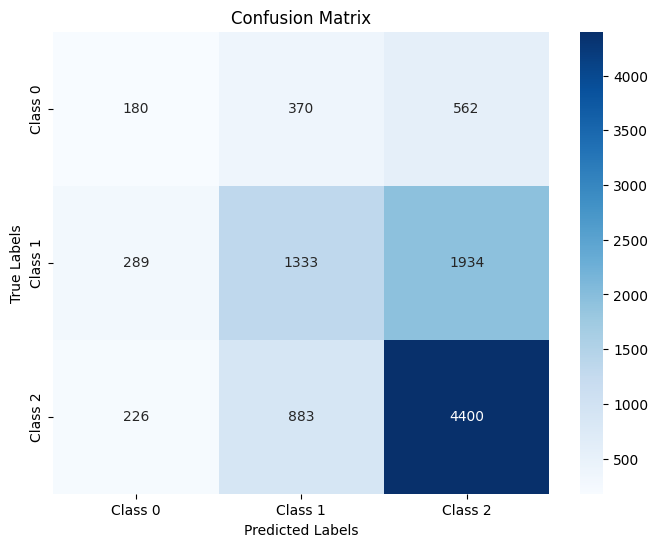

In [52]:
y_pred = rf_model.predict(X_test_)


print("Classification Report:\n")
print(classification_report(y_test_, y_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Step 4: Confusion Matrix
conf_matrix = confusion_matrix(y_test_, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### Super Learners

- DNN
- etc.